<a href="https://colab.research.google.com/github/vinayshanbhag/cloudvisionproductsearch/blob/main/Google_Cloud_Vision_Product_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install google cloud vision
!pip3 install -U pip google-cloud-vision

In [ ]:
# add credentials file "key.json" and set env var
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/key.json"

In [ ]:
# clone product images for faster access
!git clone https://github.com/vinayshanbhag/images.git

# Upload test images to /content/test_images

# Google Vision product search catalog
project_id = '<project_id>'
location = '<location>'
product_set_id = '<product_set>' 
product_category = 'general-v1'
filter = ''

from google.cloud import vision

# Given a product photo, return matching products in the catalog
def get_similar_products_file(
        project_id, location, product_set_id, product_category,
        file_path, filter):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: (color = red OR color = blue) AND style = kids
        It will search on all products with the following labels:
        color:red AND style:kids
        color:blue AND style:kids
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)

    index_time = response.product_search_results.index_time
    #print('Product set index time: ')
    #print(index_time)

    results = response.product_search_results.results
    ret = []
    for result in results:
        product = result.product
        prd = dict()
        prd['confidence'] = f"{result.score:.2f}"
        prd['image'] = f'/content/images/{result.image.split("/")[-1]}.jpg'
        prd['product_name'] = product.display_name
        ret.append(prd)
    return ret

mkdir: cannot create directory ‘/content/images’: File exists
mkdir: cannot create directory ‘/content/test_images’: File exists


In [ ]:
# Capture from web cam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/test_images/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Detect';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

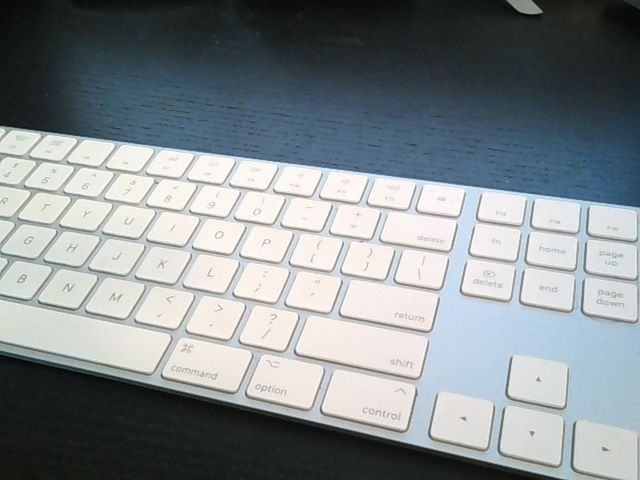

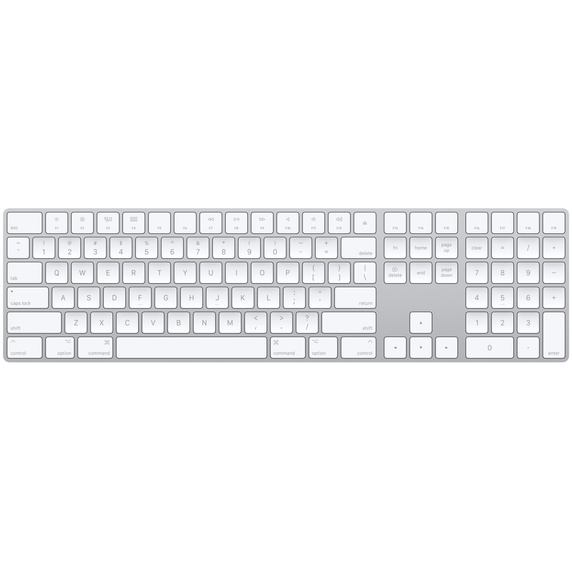

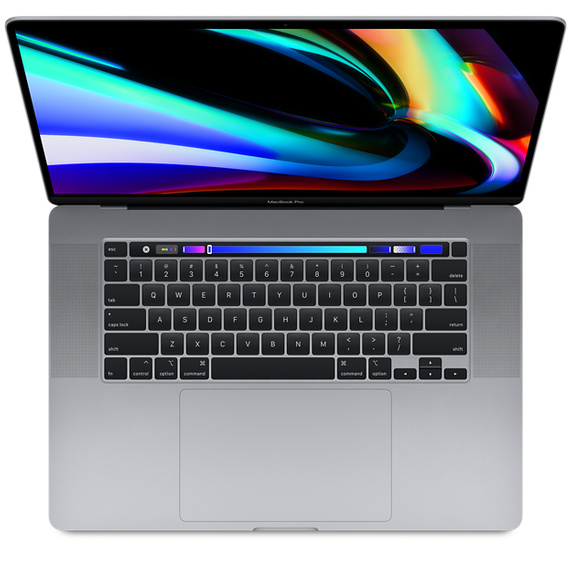

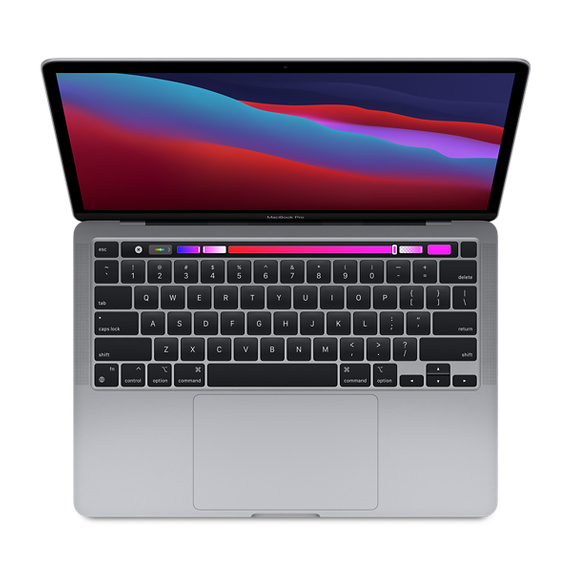

In [115]:
from IPython.display import display, HTML, Image

try:
  query_image = take_photo() #'/or/path/to/test_image' #
  results = get_similar_products_file(
    project_id,
    location,
    product_set_id, 
    product_category,
    query_image,
    filter
  )
  display(HTML('<h3>Product Image being searched</h3>'))
  display(Image(query_image, width=250))
  display(HTML('<h3>Search Results</h3><br><hr>'))
  for idx, result in enumerate(results[:3]):
    display(HTML(f"<p>{result['product_name']}</p>"))
    display(HTML(f"<p>Confidence: {result['confidence']}</p>"))
    if idx==0:display(Image(result['image'], width=250))
    else:display(Image(result['image'], width=50))
    print()
except Exception as err:
  # No webcam or no permission to access web cam
  print(str(err))

In [ ]:
#https://cloud.google.com/vision#section-11